# MATRIC FACTORIZATION PROJECT                      
                                                                                                         92iFactorization 
                                                                                 Ryan BELKHIR, Tom DUVAL, Salomé PAPEREUX
                                                      

In [1]:
import numpy as np
import pandas as pd
import csv
import time
from tqdm import tqdm
import numba as nb
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes


from numpy import genfromtxt
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy import linalg
from scipy.special import logsumexp
from sklearn.utils import extmath
from typing import NamedTuple, Tuple



ModuleNotFoundError: No module named 'kmodes'

## DATA INITIALIZATION  

Importation of data

In [2]:
df_100k = pd.read_csv("ratings.csv")
print(df_100k)

df = pd.read_csv('ratings.dat', sep="::",header=None, engine='python')
df = df.rename(columns={0: 'userId', 1:'movieId', 2:'rating', 3:'timestamp'})
print(df)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
         userId  movieId  rating  timestamp
0             1     1193       5  978300760
1             1      661       3  978302109
2             1      914       3  978301968
3             1     3408       4  978300275
4             1     2355       5  978824291
...         ...      ...     ...        ...
1000204    6040     1091       1  956716541
1000205    6040     1094       5  956704887
1000206    6040      562       5  956704746
10002

Hyperparameters settigns, and initialisation of rating matrix R

In [3]:
n = len(set(df['userId']))
m = len(set(df['movieId']))
K = 7
rates = len(df)

print("Number of Users: {}".format(n))
print("Number of Movies: {}".format(m))
print("Number of Ratings : {}".format(rates))

Number of Users: 6040
Number of Movies: 3706
Number of Ratings : 1000209


We compute the matrices M_info and U_info, that contains informations about the movies (action, thriller...) and the users (sex, age, working situation...).

In [45]:
df_genre = pd.read_csv('movies.dat', sep="::",header=None, engine="python")
df_genre = df_genre.rename(columns = {0: 'id' ,1: 'title', 2: 'genre'})

df_title = pd.DataFrame(df_genre.title.str.rsplit('(',1).tolist())
df_title = df_title.rename(columns = {0: 'title' , 1: 'year'})

df_date = pd.DataFrame(df_title.year.str.rsplit(')',1).tolist())

df_movies = pd.concat([df_title['title'], df_date[0]], axis=1, ignore_index=True)
df_movies = pd.concat([df_movies, df_genre['genre']], axis=1, ignore_index=True)

n0, _ = df_movies.shape
genres = np.zeros((n0, 18))


'''Each column represents a type of movie, ex column 1: Action'''
for i in range (n0):
    if 'Action' in df_movies[2][i]:
        genres[i][0] = 1
    if 'Adventure' in df_movies[2][i]:
        genres[i][1] = 1
    if 'Animation' in df_movies[2][i]:
        genres[i][2] = 1
    if "Children" in df_movies[2][i]:
        genres[i][3] = 1 
    if 'Comedy' in df_movies[2][i]:
        genres[i][4] = 1
    if 'Crime' in df_movies[2][i]:
        genres[i][5] = 1
    if 'Documentary' in df_movies[2][i]:
        genres[i][6] = 1
    if 'Drama' in df_movies[2][i]:
        genres[i][7] = 1
    if 'Fantasy' in df_movies[2][i]:
        genres[i][8] = 1
    if 'Film-Noir' in df_movies[2][i]:
        genres[i][9] = 1
    if 'Horror' in df_movies[2][i]:
        genres[i][10] = 1
    if 'Musical' in df_movies[2][i]:
        genres[i][11] = 1
    if 'Mystery' in df_movies[2][i]:
        genres[i][12] = 1
    if 'Romance' in df_movies[2][i]:
        genres[i][13] = 1
    if 'Sci-Fi' in df_movies[2][i]:
        genres[i][14] = 1
    if 'Thriller' in df_movies[2][i]:
        genres[i][15] = 1
    if 'War' in df_movies[2][i]:
        genres[i][16] = 1
    if 'Western' in df_movies[2][i]:
        genres[i][17] = 1

df_movies = df_movies.drop(0, axis=1)
df_allgenres = pd.DataFrame(genres)
df_movies = pd.concat([df_movies, df_allgenres], axis=1, ignore_index=True)
df_movies_temp = df_movies.drop(0, axis=1)
df_movies_temp = df_movies_temp.drop(1, axis=1)


M_info = df_movies_temp.to_numpy()

print(M_info)


[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [6]:
df_users = pd.read_csv('users.dat', sep="::",header=None, engine='python')
df_users = df_users.drop(0, axis=1)

df_users = df_users.drop(4, axis=1)
U_info = df_users.to_numpy()
U_info[U_info=='F'] = 0
U_info[U_info=='M'] = 1
print(U_info)

[[0 1 10]
 [1 56 16]
 [1 25 15]
 ...
 [0 56 1]
 [0 45 0]
 [1 25 6]]


Bijection between movies id and R's colonne id

In [7]:
idx = {}
new_id = 0
for movie_id in list(df['movieId']):
    if movie_id not in idx.keys():
        idx[movie_id] = new_id
        new_id += 1
        
idx_M_info = {}
new_id = 0

for movie_id in list(df_genre['id']):
    if new_id not in idx_M_info.keys():
        idx_M_info[new_id] = movie_id
        new_id += 1

        
rev_idx = {}        
for key in list(idx_M_info.keys()):
    if idx_M_info[key] in idx.keys():
        val = idx[idx_M_info[key]]
        rev_idx[val] = key


def get_new_id(old_idx):
    new_idx = []
    for id in old_idx:
        if idx_M_info[id] in idx.keys():
            new_id = idx[idx_M_info[id]]
            new_idx.append(new_id)
        
    return new_idx

Creation of the matrix R containing ratings, with rows user, and row movies

In [8]:
def fullfill_matrix():
    R = np.zeros((n,m))
    for l in range(rates):
        i = df['userId'].iloc[l] - 1
        movie_id = df['movieId'].iloc[l]
        j = idx[movie_id]
        rij = df.iloc[l,2]

        R[i][j] = rij
            
    return R

R = fullfill_matrix()
print(R)

[[5. 3. 3. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]]


We split the matrix R, into train and test matrices where the test matrix is exactly one rate for every user

In [9]:
def train_test(R):
    R_train = np.copy(R)
    R_test = np.zeros((n, m))
    for i in range(n):
        cols = np.where(R_train[i,:] > 0)[0]
        j = np.random.choice(cols)
        R_test[i][j] = R_train[i][j]
        R_train[i][j] = 0
    
    return R_train, R_test

R_train, R_test = train_test(R)

Rating distribution according to the user and movie

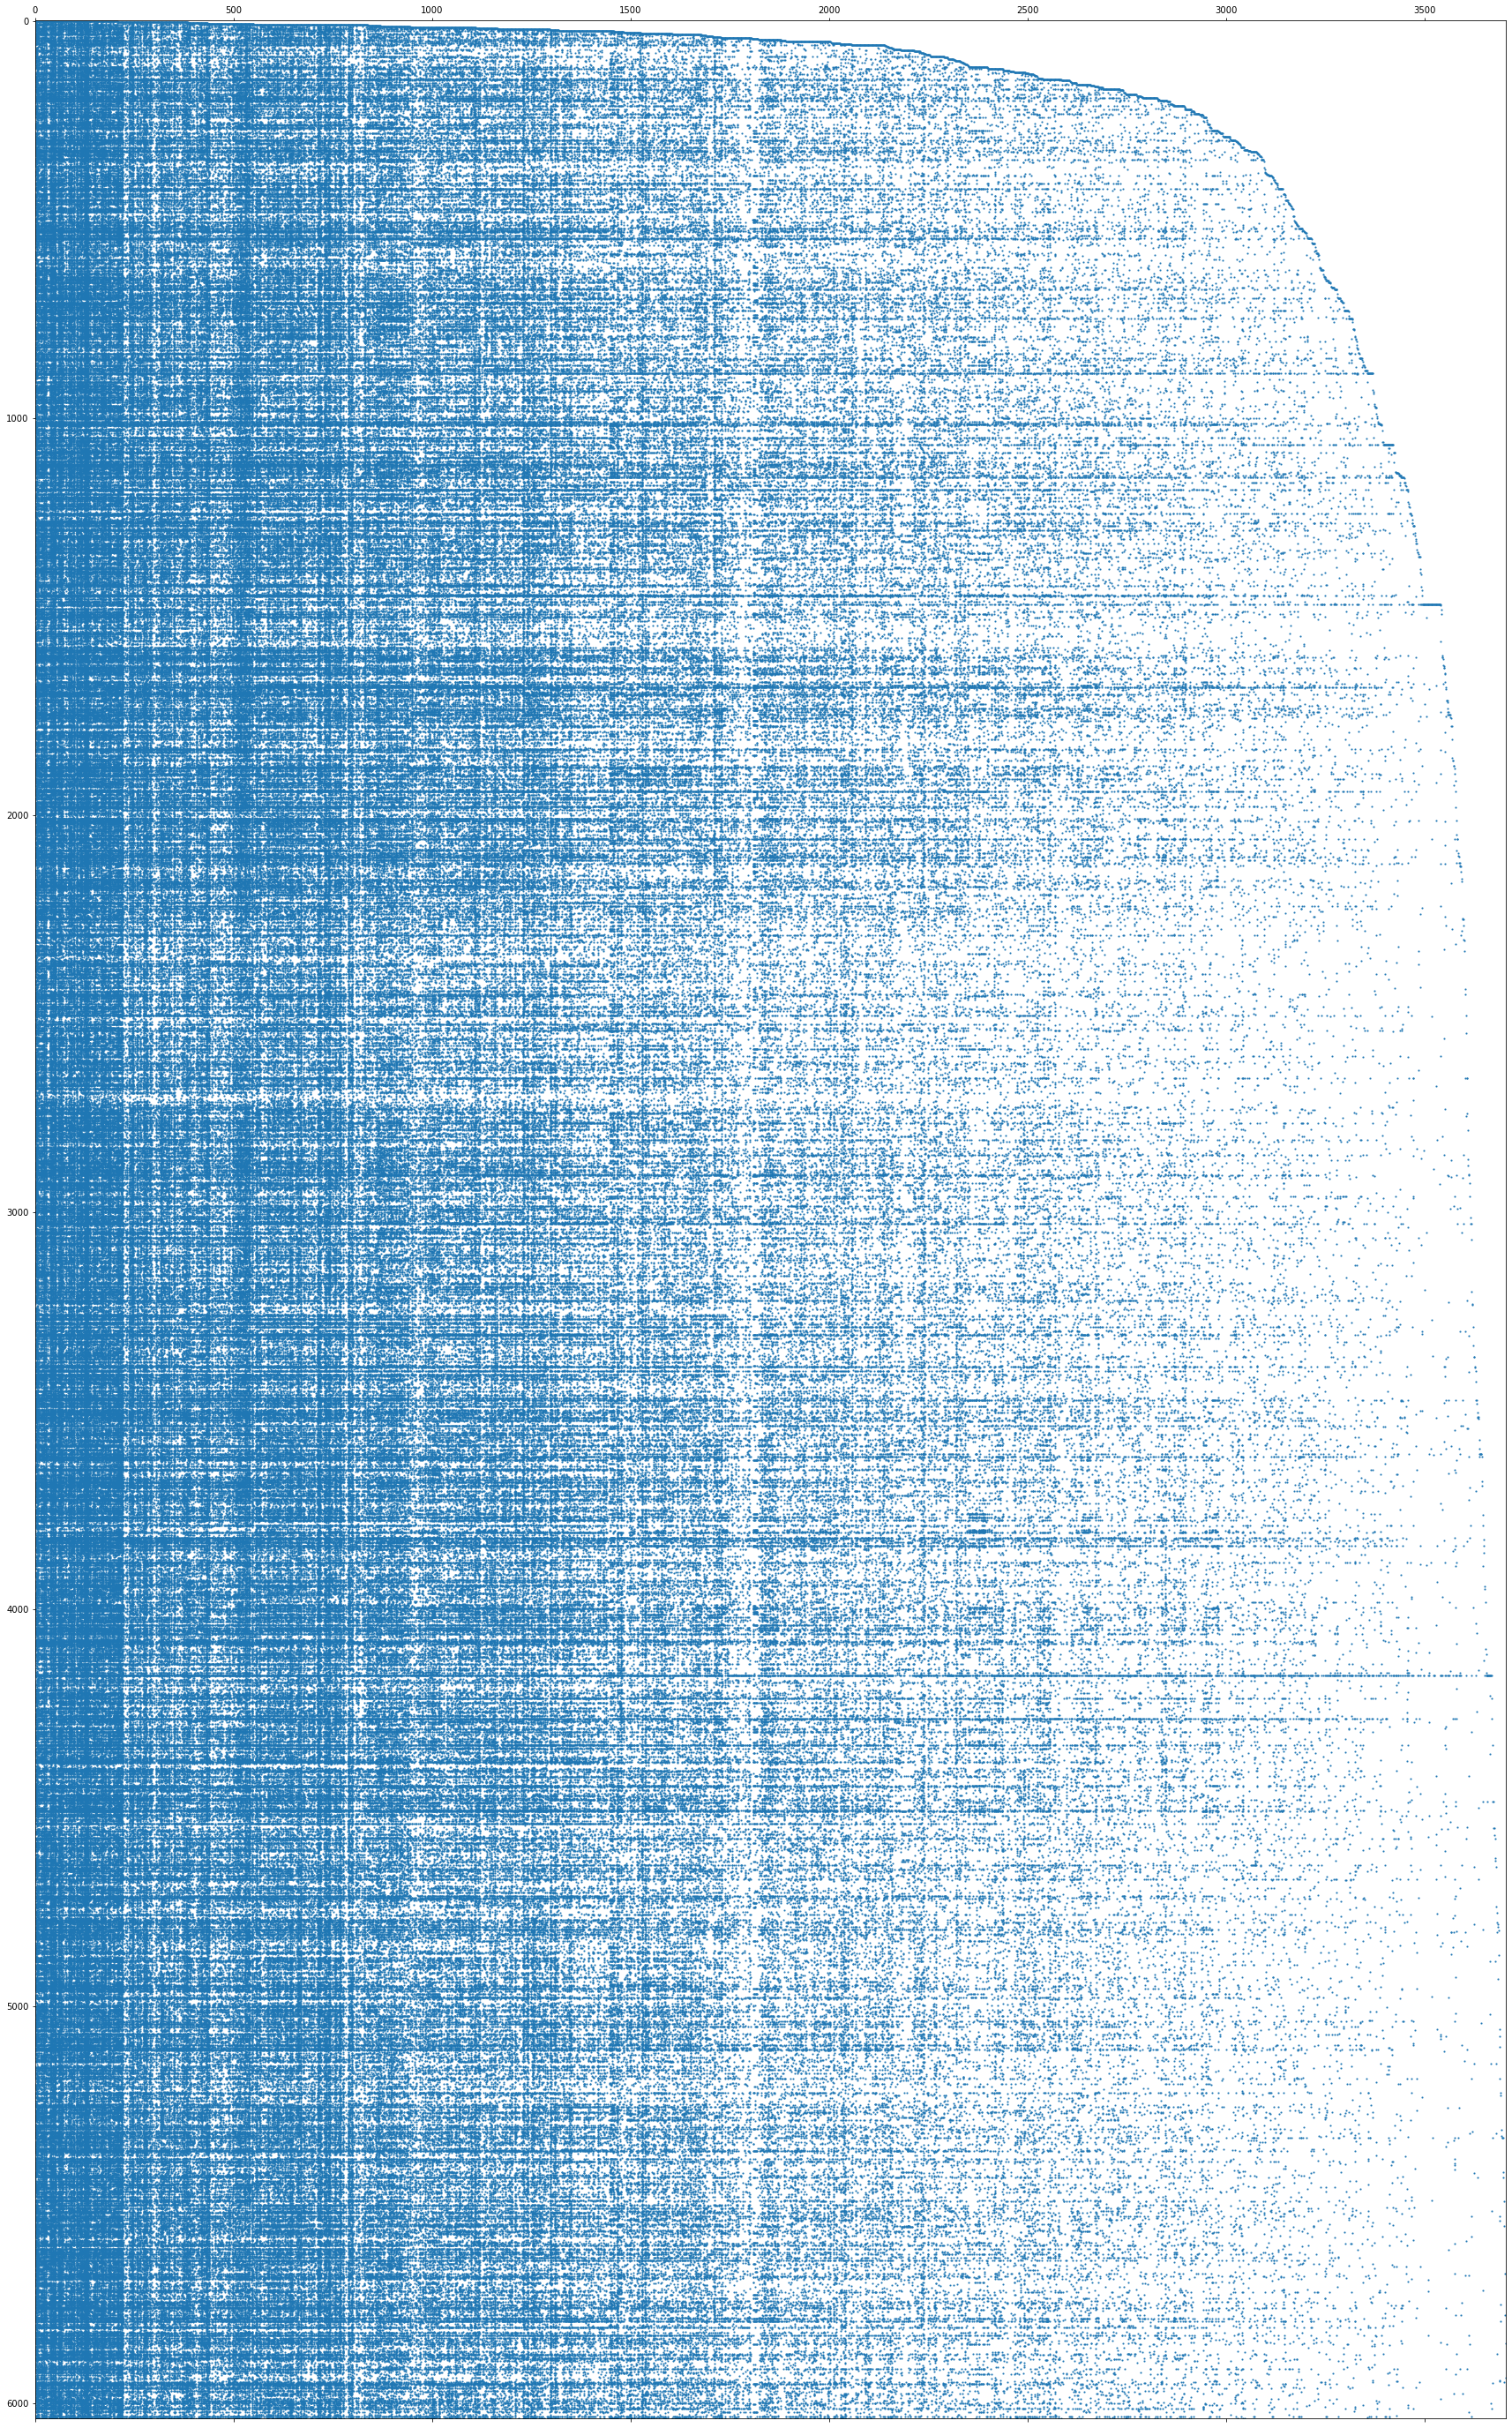

In [10]:
plt.figure(figsize=(50,50))
plt.spy(R, markersize=1)

## MATRIX FACTORIZATION 

Initialisation of user-based and movie-based matrices

In [11]:
U = np.random.random(size = (n, K))
M = np.random.random(size = (m, K))

We create the class Optimizer which will be the basis of our models

In [12]:
class Optimizer:
    def __init__(self, U, M, R, R_test, lambda_reg, epochs):
        self.U = np.copy(U)
        self.M = np.copy(M)
        self.R = np.copy(R)
        self.R_test = np.copy(R_test)
        self.lambda_reg = lambda_reg
        self.epochs = epochs
        self.history = {"train": [],
                        "test": [],
                        "time": []}

    def update_time(self, t0):
        """Update the computational time in the history"""
        t1 = time.time()
        self.history["time"].append(t1 - t0)

    def score(self):
        """Compute the RMSE of the model and update the history"""
        R_hat = self.U @ self.M.T
        R_hat = R_hat[self.R > 0]
        R_pos = self.R[self.R > 0]
        err = np.sqrt(np.square(R_pos - R_hat).mean())
        self.history["train"].append(err)
        return err

    def test(self):
        """Compute the RMSE of the model on the test set and update the history"""
        R_hat = self.U @ self.M.T
        R_hat = R_hat[self.R_test > 0]
        R_pos = self.R_test[self.R_test > 0]
        err = np.sqrt(np.square(R_pos - R_hat).mean())
        self.history["test"].append(err)
        return err

    def plot_history(self):
        print("train error:", self.history["train"][-1])
        print("test error:", self.history["test"][-1])

        plt.plot(np.arange(0, len(self.history["train"])), self.history["train"], label='train')
        plt.plot(np.arange(0, len(self.history["test"])), self.history["test"], label='test')
        plt.legend()
        plt.title('Precision of the model according to time')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.plot()

    def fit(self):
        pass

    # About cross validation

    def k_folds(self, Ratings, k=10):
        """Returns K-Folds with at least one rating for every user"""
        R_copy = np.copy(Ratings)
        n, m = R_copy.shape
        folds = []
        for _ in range(k):
            fold = np.zeros((n, m))
            for i in range(n):
                cols = np.where(R_copy[i, :] > 0)[0]
                j = np.random.choice(cols)
                fold[i][j] = R_copy[i][j]
                R_copy[i][j] = 0
            folds.append(fold)

        col, row = np.where(R_copy)
        coord = np.array(list((zip(col, row))))
        np.random.shuffle(coord)
        data_split = np.array_split(coord, k)

        for idx, data in enumerate(data_split):
            for i, j in data:
                folds[idx][i, j] = R_copy[i, j]
                R_copy[i, j] = 0

        return folds

    def train_test_folds(self, folds, idx):
        """Return the idx Fodds as a test set and combine the others as a train set"""
        train = np.zeros((n, m))
        test = np.zeros((n, m))

        for i in range(len(folds)):
            if i != idx:
                train += folds[i]
            else:
                test = folds[i]
        return train, test

    def cross_validation(R, parameters, k=10):
        pass

# Gradient Descent

train error: 0.9007306354747315
test error: 0.9422218158834724


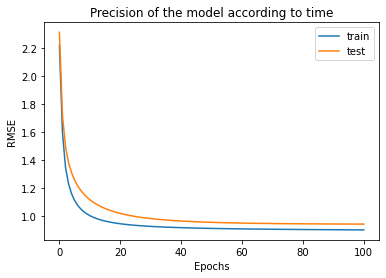

In [13]:
class GradientDescent(Optimizer):
    def __init__(self, lr, U=U, M=M, R=R_train, R_test=R_test, lambda_reg=0.002, epochs=100):
        super().__init__(U, M, R, R_test, lambda_reg, epochs)
        self.lr = lr
        self.best_param = {"learning_rate": 0,
                           "lambda": 0,
                           "K": 0}
        self.best_rmse = None

    def fit(self):
        t = time.time()
        self.score()
        self.test()

        for epoch in range(self.epochs):
            R_hat = self.U @ self.M.T
            # R_hat = np.einsum("ik,jk->ij", U, M)
            R_hat[self.R <= 0] = 0
            E = self.R - R_hat

            U_temp = self.U + self.lr * (2 * E @ self.M - 2 * self.lambda_reg * self.U)
            M_temp = self.M + self.lr * (2 * E.T @ self.U - 2 * self.lambda_reg * self.M)
            self.U = U_temp
            self.M = M_temp

            self.score()
            self.test()
            self.update_time(t)

        # self.plot_history()
        return self.U, self.M

    # About cross validation

    def cross_validation(self, Ratings, parameters, k=10):
        folds = self.k_folds(Ratings, k)
        best_param = {"learning_rate": 0,
                      "lambda": 0,
                      "K": 0}
        best_rmse = None

        for latent_vector in parameters['K']:
            U = np.random.random(size=(n, latent_vector))
            M = np.random.random(size=(m, latent_vector))
            for lr in parameters['learning_rate']:
                for reg in parameters['lambda']:
                    errors = []
                    for i in range(k):
                        R_tr, R_te = self.train_test_folds(folds, i)
                        gd_cv = GradientDescent(lr, U, M, R_tr, R_te, lambda_reg=reg)
                        gd_cv.fit()
                        e = gd_cv.test()
                        errors.append(e)

                    if best_rmse is None or np.mean(errors) < best_rmse:
                        best_rmse = np.mean(errors)
                        best_param["learning_rate"] = lr
                        best_param["lambda"] = reg
                        best_param["K"] = latent_vector

        self.best_rmse = best_rmse
        self.best_param = best_param
        return best_rmse, best_param

gd = GradientDescent(0.0001)
U_gd, M_gd = gd.fit()
gd.plot_history()


Cross Validation for the gradient descent

In [ ]:
parameters_GD = {
    "learning_rate":[ 0.00005],
    "lambda":[0 ,1],
    "K":[10]
}
gd.cross_validation(R_train, parameters_GD)

In [ ]:
print(gd.best_param)
print(gd.best_rmse)

# Stochastic Gradient Descent

train error: 0.8478895448282557
test error: 0.8988101813808903


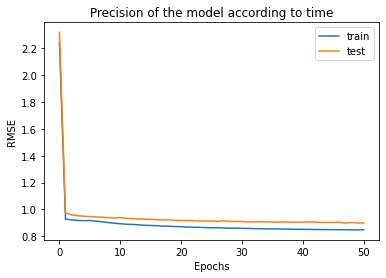

In [15]:
from numba import njit

U = np.random.random(size = (n, K))
M = np.random.random(size = (m, K))

@njit
def compute_sgd(R, U, M, S, lambda_reg, lr):
    """Compute a SGD iteration with numba to accelerate the process"""
    for i, j in S:
        eij = R[i][j] - (U[i][:] @ M[j][:])
        ui_temp = U[i][:] + lr * (eij * M[j][:] - lambda_reg * U[i][:])
        mj_temp = M[j][:] + lr * (eij * U[i][:] - lambda_reg * M[j][:])

        U[i][:], M[j][:] = ui_temp, mj_temp

    return U, M


class SGD(Optimizer):
    def __init__(self, lr, U=U, M=M, R=R_train, R_test=R_test, lambda_reg=0.1, epochs=50):
        super().__init__(U, M, R, R_test, lambda_reg, epochs)
        self.lr = lr

    def fit(self):
        n, m = self.R.shape
        t = time.time()
        self.score()
        self.test()

        row, col = np.where(self.R > 0)
        S = nb.typed.List(list(zip(row, col)))

        for _ in range(self.epochs):
            np.random.shuffle(S)

            R = self.R
            U = self.U
            M = self.M
            lambda_reg = self.lambda_reg
            lr = self.lr

            self.U, self.M = compute_sgd(R, U, M, S, lambda_reg, lr)

            self.score()
            self.test()
            self.update_time(t)
        #self.plot_history()

        return self.U, self.M
    

sgd = SGD(0.01)
U_sgd, M_sgd = sgd.fit()
sgd.plot_history()

# Alternating Least Squares

train error: 0.8099487359529892
test error: 0.8973695444481276


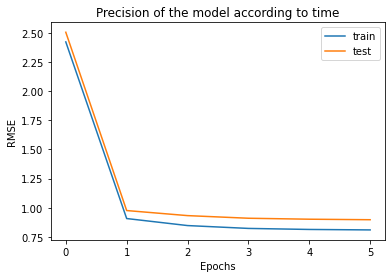

In [26]:
K = 6

U = np.random.random(size = (n, K))
M = np.random.random(size = (m, K))

class ALS(Optimizer):
    def __init__(self, latent_vector, U=U, M=M, R=R_train, R_test=R_test, lambda_reg=4, epochs=5):
        super().__init__(U, M, R, R_test, lambda_reg, epochs)
        self.latent_vector = latent_vector

    def fit(self):
        self.score()
        self.test()

        n, m = self.R.shape

        # Create a mask W to only consider the ratings > 0
        W = np.zeros((n, m))
        W[self.R > 0] = 1

        for step in range(self.epochs):
            for i in range(n):
                M_temp = np.multiply(self.M.T, W[i, :])
                self.U[i, :] = np.linalg.inv(
                    M_temp @ self.M + self.lambda_reg * np.eye(self.latent_vector)) @ M_temp @ self.R[i, :]
            for j in range(m):
                U_temp = np.multiply(self.U.T, W[:, j])
                self.M[j, :] = np.linalg.inv(
                    U_temp @ self.U + self.lambda_reg * np.eye(self.latent_vector)) @ U_temp @ self.R[:, j]

            self.score()
            self.test()

        # self.plot_history()
        return self.U, self.M

    def fit_clusterize(self):
        """Compute an ALS method where the mask also consider the users and/or movies of a same cluster"""
        self.score()
        self.test()

        n, m = self.R.shape
        kmeans_users = KMeans(7)
        kmeans_users.fit(U_info)
        masks_users = kmeans_users.compute_masks_users(self.R)

        kmeans_movies = KMeans(22)
        kmeans_movies.fit(M_info)
        masks_movies = kmeans_movies.compute_masks_movies(self.R)
        # W = np.zeros((n,m))
        # W[self.R>0] = 1

        for step in range(self.epochs):
            for i in range(n):
                cluster_idx = kmeans_users.labels[i]
                mask = masks_users[cluster_idx]
                M_temp = np.multiply(self.M.T, mask[i, :])
                self.U[i, :] = np.linalg.inv(
                    M_temp @ self.M + self.lambda_reg * np.eye(self.latent_vector)) @ M_temp @ self.R[i, :]
            for j in range(m):
                col_idx = rev_idx[str(j)]

                cluster_idx = kmeans_movies.labels[int(col_idx)]
                mask = masks_movies[cluster_idx]
                U_temp = np.multiply(self.U.T, mask[:, j])
                self.M[j, :] = np.linalg.inv(
                    U_temp @ self.U + self.lambda_reg * np.eye(self.latent_vector)) @ U_temp @ self.R[:, j]

            self.score()
            self.test()

        self.plot_history()

        return self.U, self.M

    def cross_validation(self, Ratings, parameters, k=10):
        folds = self.k_folds(Ratings, k)
        best_param = {
            "lambda": 0,
            "K": 0}
        best_rmse = None

        for latent_vector in parameters['K']:
            U = np.random.random(size=(n, latent_vector))
            M = np.random.random(size=(m, latent_vector))
            for reg in parameters['lambda']:
                errors = []
                for i in range(k):
                    R_tr, R_te = self.train_test_folds(folds, i)
                    als_cv = ALS(lr, U, M, R_tr, R_te, lambda_reg=reg)
                    als_cv.fit()
                    e = als_cv.test()
                    errors.append(e)
                if best_rmse is None or np.mean(errors) < best_rmse:
                    best_rmse = np.mean(errors)
                    best_param["lambda"] = reg
                    best_param["K"] = latent_vector

        return best_rmse, best_param

als = ALS(K)
U_als, M_als = als.fit()
als.plot_history()


Cross Validation for ALS:

In [ ]:
parameters_ALS = {
    "lambda":[1, 2, 3, 3.5, 4],
    "K":[3,5,7,10, 15, 25]
}

als.crossvalidation(R_train, parameters_ALS)
print(als.best_param)
print(als.best_rmse)

# SVD

train error: 0.825653180986199
test error: 0.9219273243339905


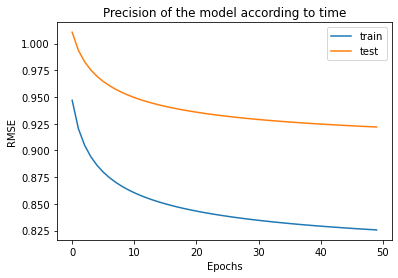

In [31]:
import sklearn.metrics.pairwise as pw

class SVD(Optimizer):
    def __init__(self, latent_vector, U=None, M=None, R=R_train, R_test=R_test, lambda_reg=None, epochs=50):
        super().__init__(U, M, R, R_test, lambda_reg, epochs)
        self.latent_vector = latent_vector
        self.similarity_U = None
        self.similarity_M = None

    def fit(self):
        """Compute a SVD that take in consideration the missing entries by replacing them by the means of the user's rate
        according to the book
        """
        t = time.time()
        Rf = np.copy(self.R)
        n, m = Rf.shape

        # Initialisation

        mean_user = self.R.sum(1) / np.sum(self.R != 0, axis=1)
        for i in range(n):
            pos = np.where(self.R[i] == 0)
            Rf[i, pos] = mean_user[i]

        # Iterative steps
        for _ in range(self.epochs):
            Q, E, P = extmath.randomized_svd(Rf, self.latent_vector)

            self.U = Q @ np.diag(E)
            self.M = (P).T

            Rf = self.U @ self.M.T
            # We replace originally missing values by values in Rf
            Rf[np.where(self.R != 0)] = 0
            Rf += self.R

            self.score()
            self.test()
            self.update_time(t)

        # self.plot_history()
        return self.U, self.M

    def GD_ALS_method(self, lr, method):
        """ ALS or Gradient Descent methods with an SVD initialization"""
        t = time.time()
        Rf = np.copy(self.R)
        n, m = Rf.shape

        # Initialisation
        moy_user = self.R.sum(1) / np.sum(self.R != 0, axis=1)
        for i in range(n):
            pos = np.where(self.R[i] == 0)
            Rf[i, pos] = moy_user[i]

        Q, E, P = extmath.randomized_svd(Rf, self.latent_vector)
        self.U = Q @ np.diag(E)
        self.M = (P).T
        Rf = self.U @ self.M.T

        # Gradient descent
        if method == 'ALS':
            svd_method = ALS(self.latent_vector, self.U, self.M, R_train, R_test, lambda_reg=1, epochs=5)
        else:
            svd_method = GradientDescent(lr, self.U, self.M, R_train, R_test, lambda_reg=0.002, epochs=200)
        svd_method.fit()

        return svd_method.U, svd_method.M

    def cross_validation(self, parameters, k):
        folds = self.k_folds(Ratings, k)
        best_param = {
            "K": 0}
        best_rmse = None

        for latent_vector in parameters['K']:
            U = np.random.random(size=(n, latent_vector))
            M = np.random.random(size=(m, latent_vector))
            errors = []
            for i in range(k):
                R_tr, R_te = self.train_test_folds(folds, i)
                svd_cv = SVD(latent_vector)
                svd_cv.fit()
                e = svd_cv.test()
                errors.append(e)
            if best_rmse is None or np.mean(errors) < best_rmse:
                best_rmse = np.mean(errors)
                best_param["K"] = latent_vector

        return best_rmse, best_param

svd = SVD(latent_vector=6, epochs=50)
U_svd, M_svd = svd.fit() 
svd.plot_history()

Cross validation for SVD:

In [ ]:
parameters_SVD = {
    "K":[2, 3, 4, 5, 6, 7, 8, 9, 10]
}

svd = SVD(latent_vector=3, epochs = 50)
best_rmse, best_param = svd.cross_validation(parameters_SVD, 8) 
print("Best RMSE : ", best_rmse)
print("Best parameters : ", best_param)

# K-Means

In [32]:
class KMeans():
    
    
    def __init__(self, k_cluster, max_iter=100, n_init = 10):
        self.k_cluster = k_cluster
        self.max_iter = max_iter
        self.n_init = n_init
        
        
    def update_centroids(self, X, labels):
        centroids = np.zeros((self.k_cluster, X.shape[1]))
        for k in range(self.k_cluster):
            centroids[k,:] = np.mean(X[labels==k, :], axis=0)
            
        return centroids      
    
        
    def distance(self, X, centroids):
        d = np.zeros((X.shape[0], self.k_cluster))
        for k in range(self.k_cluster):
            d[:,k] = np.square(np.linalg.norm(X - centroids[k,:], axis=1))
    
        return d
    
    
    def score(self, X, labels, centroids):
        d = np.zeros((X.shape[0]))
        for k in range(self.k_cluster):
            d[labels==k] = np.linalg.norm(X[labels==k] - centroids[k,:], axis=1)
        
        return np.sum(np.square(d))
    
    
    def run(self, X):
        
        permutation = np.random.permutation(np.unique(X, axis=0).shape[0])
        centroids = np.unique(X, axis=0)[permutation[:self.k_cluster]]

        for i in range(self.max_iter):
            old_centroids = centroids
            d = self.distance(X, old_centroids)
            labels = np.argmin(d, axis=1)
            centroids = self.update_centroids(X, labels)
            if np.all(old_centroids == centroids):
                break
                
        error = self.score(X, labels, centroids)
        
        return centroids, labels, error
    
    
    def fit(self, X, normalize):
        
        X = np.copy(X)
        if normalize: 
            X_mean = np.mean(X, axis=0)
            X_std = np.std(X, axis=0)
            X -= X_mean
            X /= X_std
        
        best_error = None
        
        for i in range(self.n_init):
            centroids, labels, error = self.run(X)
            if best_error is None or error < best_error:
                best_centroids = centroids
                best_labels = labels
                best_error = error
                
        self.centroids = best_centroids
        self.labels = best_labels
        self.error = best_error 
        self.compute_clusters()
                
        
    def predict(self, X):
        d = self.distance(X, self.centroids)
        return np.argmin(d, axis=1)
    
    
    def compute_clusters(self):
        clusters = []
        for k in range(self.k_cluster):
            idx = np.where(self.labels == k)[0]
            clusters.append(list(idx))
        self.clusters = clusters
        
    def compute_masks_users(self, R):
        masks = []
        size = R.shape
        for k in range(self.k_cluster):
            mask = np.zeros((size))
            for i in self.clusters[k]:
                mask[i, :] = 1
                
            mask[R==0] = 0
            masks.append(mask)
            
        return masks
    
    def compute_masks_movies(self, R):
        
        masks = []
        size = R.shape
        for k in range(self.k_cluster):
            mask = np.zeros((size))
            for j in self.clusters[k]:
                if idx_M_info[str(j)] in idx.keys(): 
                    col_idx = idx[idx_M_info[str(j)]]
                    mask[:, col_idx] = 1
                
            mask[R==0] = 0
            masks.append(mask)
            
        return masks
    


Because our implemantion of the K-Means was much slower than the sklearn one, we re-implemented the compute_clusters method from our class to use is it on the sklearn class

In [33]:
def compute_clusters(labels, k_cluster):
    clusters = []
    for k in range(k_cluster):
        idx = np.where(labels == k)[0]
        clusters.append(list(idx))
        
    return clusters

## Silhouette and Elbow methods

We implemented the silhouette and elbow method to find the best K for K-Means and K-Modes

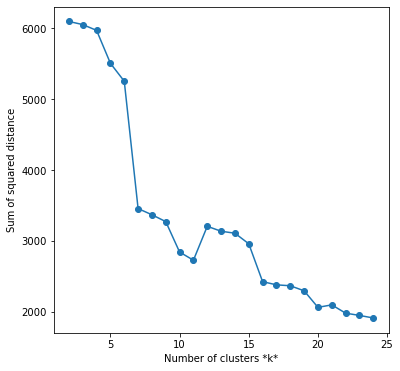

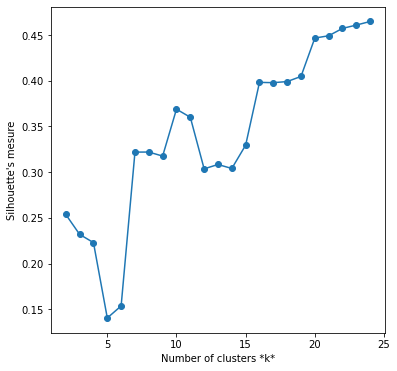

In [54]:
from sklearn.metrics import silhouette_score

    
def silhouette_elbow_method(X, list_k):
    errors = []
    sil = []
    for k in list_k:
        kmeans = KModes(k)
        kmeans.fit(X)
        errors.append(kmeans.cost_)
        labels = kmeans.labels_
        sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, errors, '-o')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance')
    plt.plot()
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sil, '-o')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel("Silhouette's mesure")
list_k = list(range(2,25))
silhouette_elbow_method(M_info, list_k)

# Clusterize Methods

We define a class that will be the basis of our clusterize class :

In [51]:
class Optimizer_clusterize:

    def __init__(self, latent_vector, mode, R, R_test, k_users, k_movies, lambda_reg, epochs):
        self.latent_vector = latent_vector

        # Mode "users" if we want to cluster the users, "movies" to cluster the movies and "both" to cluster
        # movies and users at the same time
        self.mode = mode
        self.R = R
        self.R_test = R_test
        self.k_users = k_users
        self.k_movies = k_movies
        self.lambda_reg = lambda_reg
        self.epochs = epochs
        self.history = {"train": [],
                        "test": [],
                        "time": []}

    def update_time(self, t0):
        """Update the computational time in the history"""
        t1 = time.time()
        self.history["time"].append(t1 - t0)

    def score(self):
        """Compute the RMSE of the model and update the history by checking every submatrix of R according
         the clusters they represent"""
        if (self.mode == 'users' or self.mode == 'movies'):
            val = []
            for k in range(len(self.submatrices_R)):
                R_hat = self.submatrices_U[k] @ self.submatrices_M[k].T
                R_hat = R_hat[self.submatrices_R[k] > 0].flatten()
                R_pos = self.submatrices_R[k][self.submatrices_R[k] > 0].flatten()
                val += np.square(R_pos - R_hat).tolist()
            val = np.array(val)
            err = np.sqrt(val.mean())
            self.history["train"].append(err)

        elif (self.mode == 'both'):
            val = []
            for k in range(len(self.submatrices_R)):
                for k2 in range(len(self.submatrices_R[k])):
                    R_hat = self.submatrices_U[k][k2] @ self.submatrices_M[k][k2].T
                    R_hat = R_hat[self.submatrices_R[k][k2] > 0].flatten()
                    R_pos = self.submatrices_R[k][k2][self.submatrices_R[k][k2] > 0].flatten()
                    val += np.square(R_pos - R_hat).tolist()
            val = np.array(val)
            err = np.sqrt(val.mean())
            self.history["train"].append(err)

        return err

    def test(self):
        """Compute the RMSE on the test set of the model and update the history by checking every submatrix of R
             according the clusters they represent"""
        if (self.mode == 'users' or self.mode == 'movies'):
            val = []
            for k in range(len(self.submatrices_R)):
                R_hat = self.submatrices_U[k] @ self.submatrices_M[k].T
                R_hat = R_hat[self.submatrices_R_test[k] > 0].flatten()
                R_pos = self.submatrices_R_test[k][self.submatrices_R_test[k] > 0].flatten()
                val += np.square(R_pos - R_hat).tolist()
            val = np.array(val)
            err = np.sqrt(val.mean())
            self.history["test"].append(err)

        else:
            val = []
            for k in range(len(self.submatrices_R)):
                for k2 in range(len(self.submatrices_R[k])):
                    R_hat = self.submatrices_U[k][k2] @ self.submatrices_M[k][k2].T
                    R_hat = R_hat[self.submatrices_R_test[k][k2] > 0].flatten()
                    R_pos = self.submatrices_R_test[k][k2][self.submatrices_R_test[k][k2] > 0].flatten()
                    val += np.square(R_pos - R_hat).tolist()
            val = np.array(val)

            err = np.sqrt(val.mean())
            self.history["test"].append(err)

        return err

    def plot_history(self):

        print("train error:", self.history["train"][-1])
        print("test error:", self.history["test"][-1])

        plt.plot(np.arange(0, len(self.history["train"])), self.history["train"], label='train')
        plt.plot(np.arange(0, len(self.history["test"])), self.history["test"], label='test')
        plt.legend()
        plt.title('Precision of the model according to time')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.plot()

    def compute_submatrix(self, cluster_users, cluster_movies, mode):
        """Divide R into submatrix according to users and/or movies clusters"""
        submatrices_R = []
        submatrices_R_test = []
        if (self.mode == 'users'):
            for k in range(self.k_users):
                submatrix_R = self.R[cluster_users[k], :]
                submatrix_R_test = self.R_test[cluster_users[k], :]

                submatrix_R_test = submatrix_R_test[:, ~np.all(submatrix_R == 0, axis=0)]
                submatrix_R = submatrix_R[:, ~np.all(submatrix_R == 0, axis=0)]

                submatrices_R.append(submatrix_R)
                submatrices_R_test.append(submatrix_R_test)

        elif (self.mode == 'movies'):
            for k in range(self.k_movies):
                movies_idx = get_new_id(cluster_movies[k])
                submatrix_R = self.R[:, movies_idx]
                submatrix_R_test = self.R_test[:, movies_idx]

                submatrix_R_test = submatrix_R_test[~np.all(submatrix_R == 0, axis=1)]
                submatrix_R = submatrix_R[~np.all(submatrix_R == 0, axis=1)]

                submatrices_R.append(submatrix_R)
                submatrices_R_test.append(submatrix_R_test)

        else:
            for k_u in range(self.k_users):
                user_submatrices_R = []
                user_submatrices_R_test = []
                for k_m in range(self.k_movies):
                    submatrix_R = self.R[cluster_users[k_u], :]
                    submatrix_R_test = self.R_test[cluster_users[k_u], :]

                    movies_idx = get_new_id(cluster_movies[k_m])
                    submatrix_R = submatrix_R[:, movies_idx]
                    submatrix_R_test = submatrix_R_test[:, movies_idx]

                    submatrix_R_test = submatrix_R_test[~np.all(submatrix_R == 0, axis=1)]
                    submatrix_R = submatrix_R[~np.all(submatrix_R == 0, axis=1)]

                    submatrix_R_test = submatrix_R_test[:, ~np.all(submatrix_R == 0, axis=0)]
                    submatrix_R = submatrix_R[:, ~np.all(submatrix_R == 0, axis=0)]

                    user_submatrices_R.append(submatrix_R)
                    user_submatrices_R_test.append(submatrix_R_test)

                submatrices_R.append(user_submatrices_R)
                submatrices_R_test.append(user_submatrices_R_test)

        self.submatrices_R = submatrices_R
        self.submatrices_R_test = submatrices_R_test

    def init_matrix(self):
        """Randomly initialize U and M matrices for every submatrix R"""
        self.submatrices_U = []
        self.submatrices_M = []
        if (self.mode == 'users'):

            for k in range(self.k_users):
                R = self.submatrices_R[k]
                U = np.random.random((R.shape[0], self.latent_vector))
                M = np.random.random((R.shape[1], self.latent_vector))
                self.submatrices_U.append(U)
                self.submatrices_M.append(M)

        elif (self.mode == 'movies'):

            for k in range(self.k_movies):
                R = self.submatrices_R[k]
                U = np.random.random((R.shape[0], self.latent_vector))
                M = np.random.random((R.shape[1], self.latent_vector))
                self.submatrices_U.append(U)
                self.submatrices_M.append(M)

        else:
            for k in range(self.k_users):
                submatrices_U_Users = []
                submatrices_M_Users = []
                for k2 in range(self.k_movies):
                    R = self.submatrices_R[k][k2]
                    U = np.random.random((R.shape[0], self.latent_vector))
                    M = np.random.random((R.shape[1], self.latent_vector))
                    submatrices_U_Users.append(U)
                    submatrices_M_Users.append(M)
                self.submatrices_U.append(submatrices_U_Users)
                self.submatrices_M.append(submatrices_M_Users)

    def fit(self):
        pass

    def run(self):
        """Create the users and/or movies clusters and compute the submatrix R and U, M for every cluster"""
        if (self.mode == 'users'):
            kmeans_users = KModes(self.k_users)
            kmeans_users.fit(U_info)
            cluster_users = compute_clusters(kmeans_users.labels_, self.k_users)
            self.compute_submatrix(cluster_users, None, mode=self.mode)
            self.init_matrix()

        elif (self.mode == 'movies'):
            kmeans_movies = KModes(self.k_movies, init='Huang', n_init=5)
            kmeans_movies.fit(M_info)
            cluster_movies = compute_clusters(kmeans_movies.labels_, self.k_movies)
            self.compute_submatrix(None, cluster_movies, mode=self.mode)
            self.init_matrix()

        else:
            kmeans_users = KModes(self.k_users)
            kmeans_users.fit(U_info)
            cluster_users = compute_clusters(kmeans_users.labels_, self.k_users)
            kmeans_movies = KModes(self.k_movies)
            kmeans_movies.fit(M_info)
            cluster_movies = compute_clusters(kmeans_movies.labels_, self.k_movies)

            self.compute_submatrix(cluster_users, cluster_movies, mode=self.mode)
            self.init_matrix()

# ALS Clusterize

train error: 0.7692584963640534
test error: 0.9287977206972843


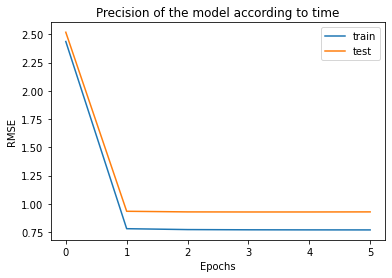

In [69]:
class ALS_clusterize(Optimizer_clusterize):
    """ Clusterize version of the ALS algorithm"""
    def __init__(self, latent_vector, mode, R=R_train, R_test=R_test, k_users=7, k_movies=20, lambda_reg=4, epochs=5):
        super().__init__(latent_vector, mode, R, R_test, k_users, k_movies, lambda_reg, epochs)

    def fit(self):
        self.run()
        self.score()
        self.test()
        if (self.mode == 'users'):

            for _ in range(self.epochs):
                for k in range(self.k_users):
                    R = self.submatrices_R[k]
                    R_test = self.submatrices_R_test[k]
                    U = self.submatrices_U[k]
                    M = self.submatrices_M[k]
                    als = ALS(self.latent_vector, R=R, R_test=R_test, U=U, M=M, lambda_reg=self.lambda_reg, epochs=5)
                    self.submatrices_U[k], self.submatrices_M[k] = als.fit()

                self.score()
                self.test()

        elif (self.mode == 'movies'):

            for _ in range(self.epochs):
                for k in range(self.k_movies):
                    R = self.submatrices_R[k]
                    R_test = self.submatrices_R_test[k]
                    U = self.submatrices_U[k]
                    M = self.submatrices_M[k]
                    als = ALS(self.latent_vector, R=R, R_test=R_test, U=U, M=M, lambda_reg=self.lambda_reg,
                              epochs=self.epochs)
                    self.submatrices_U[k], self.submatrices_M[k] = als.fit()

                self.score()
                self.test()

        else:

            for _ in range(self.epochs):
                for k in range(self.k_users):
                    for k2 in range(self.k_movies):
                        R = self.submatrices_R[k][k2]
                        R_test = self.submatrices_R_test[k][k2]
                        U = self.submatrices_U[k][k2]
                        M = self.submatrices_M[k][k2]
                        als = ALS(self.latent_vector, R=R, R_test=R_test, U=U, M=M, lambda_reg=self.lambda_reg,
                                  epochs=self.epochs)
                        self.submatrices_U[k][k2], self.submatrices_M[k][k2] = als.fit()
                self.score()
                self.test()

                # self.plot_history()
                
        

als_clust = ALS_clusterize(6, mode='users')
als_clust.fit()
als_clust.plot_history()

# SGD Clusterize

train error: 0.9053121068370865
test error: 0.955830416208969


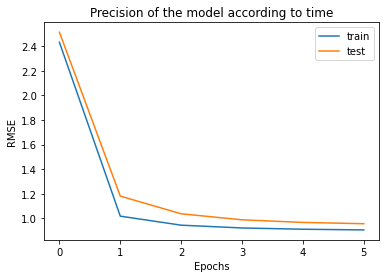

In [68]:
class SGD_clusterize(Optimizer_clusterize):
    """Clusterize version of the SGD algorithm"""

    def __init__(self, lr, latent_vector, mode, R=R_train, R_test=R_test, k_users=7, k_movies=10, lambda_reg=0.1,
                 epochs=5):
        super().__init__(latent_vector, mode, R, R_test, k_users, k_movies, lambda_reg, epochs)
        self.lr = lr

    def fit(self):
        t = time.time()
        self.run()
        self.score()
        self.test()
        self.update_time(t)
        if (self.mode == 'users'):
            for _ in range(self.epochs):
                for k in range(self.k_users):
                    R = self.submatrices_R[k]
                    R_test = self.submatrices_R_test[k]
                    U = self.submatrices_U[k]
                    M = self.submatrices_M[k]
                    sgd = SGD(0.001, R=R, R_test=R_test, U=U, M=M, lambda_reg=self.lambda_reg, epochs=5)
                    self.submatrices_U[k], self.submatrices_M[k] = sgd.fit()

                self.score()
                self.test()
                self.update_time(t)

        elif (self.mode == 'movies'):

            for _ in range(self.epochs):
                for k in range(self.k_movies):
                    R = self.submatrices_R[k]
                    R_test = self.submatrices_R_test[k]

                    R_test = R_test[~np.all(R == 0, axis=1)]
                    R = R[~np.all(R == 0, axis=1)]

                    self.submatrices_R_test[k] = self.submatrices_R_test[k][~np.all(self.submatrices_R[k] == 0, axis=1)]
                    self.submatrices_R[k] = self.submatrices_R[k][~np.all(self.submatrices_R[k] == 0, axis=1)]

                    U = self.submatrices_U[k]
                    M = self.submatrices_M[k]
                    sgd = SGD(self.lr, R=R, R_test=R_test, U=U, M=M, lambda_reg=self.lambda_reg, epochs=5)
                    self.submatrices_U[k], self.submatrices_M[k] = sgd.fit()

                self.score()
                self.test()
                self.update_time(t)

        else:

            for _ in range(self.epochs):
                for k in range(self.k_users):
                    for k2 in range(self.k_movies):
                        R = self.submatrices_R[k][k2]
                        R_test = self.submatrices_R_test[k][k2]

                        R_test = R_test[~np.all(R == 0, axis=1)]

                        R = R[~np.all(R == 0, axis=1)]
                        U = self.submatrices_U[k][k2]
                        M = self.submatrices_M[k][k2]
                        sgd = SGD(self.lr, R=R, R_test=R_test, U=U, M=M, lambda_reg=self.lambda_reg, epochs=5)
                        self.submatrices_U[k][k2], self.submatrices_M[k][k2] = sgd.fit()
                self.score()
                self.test()
                self.update_time(t)

        
sgd_clusterize = SGD_clusterize(0.01, 6, mode='users')
sgd_clusterize.fit()
sgd_clusterize.plot_history()

# Gradient Descent Clusterize

train error: 0.911420305738901
test error: 0.9778650646356535


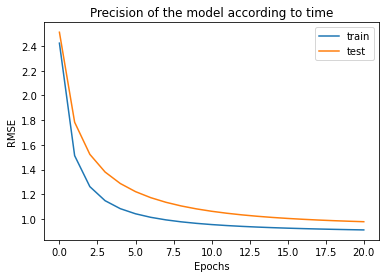

In [67]:
K= 6

U = np.random.random(size = (n, K))
M = np.random.random(size = (m, K))

class GD_clusterize(Optimizer_clusterize):
    """Clusterize version of the Gradient Descent algorithm"""
    def __init__(self, lr, latent_vector, mode, R=R_train, R_test=R_test, k_users=7, k_movies=10, lambda_reg=0.1,
                 epochs=20):
        super().__init__(latent_vector, mode, R, R_test, k_users, k_movies, lambda_reg, epochs)
        self.lr = lr

    def fit(self):
        t = time.time()
        self.run()
        self.score()
        self.test()
        self.update_time(t)
        if (self.mode == 'users'):
            for _ in range(self.epochs):
                for k in range(self.k_users):
                    R = self.submatrices_R[k]
                    R_test = self.submatrices_R_test[k]
                    U = self.submatrices_U[k]
                    M = self.submatrices_M[k]
                    gd = GradientDescent(self.lr, R=R, R_test=R_test, U=U, M=M, lambda_reg=self.lambda_reg, epochs=4)
                    self.submatrices_U[k], self.submatrices_M[k] = gd.fit()

                self.score()
                self.test()
                self.update_time(t)

        elif (self.mode == 'movies'):

            for _ in range(self.epochs):
                for k in range(self.k_movies):
                    R = self.submatrices_R[k]
                    R_test = self.submatrices_R_test[k]
                    U = self.submatrices_U[k]
                    M = self.submatrices_M[k]
                    gd = GradientDescent(self.lr, R=R, R_test=R_test, U=U, M=M, lambda_reg=self.lambda_reg, epochs=4)
                    self.submatrices_U[k], self.submatrices_M[k] = gd.fit()

                self.score()
                self.test()
                self.update_time(t)

        else:

            for _ in range(self.epochs):
                for k in range(self.k_users):
                    for k2 in range(self.k_movies):
                        R = self.submatrices_R[k][k2]
                        R_test = self.submatrices_R_test[k][k2]
                        U = self.submatrices_U[k][k2]
                        M = self.submatrices_M[k][k2]
                        gd = GradientDescent(self.lr, R=R, R_test=R_test, U=U, M=M, lambda_reg=self.lambda_reg,
                                             epochs=4)
                        self.submatrices_U[k][k2], self.submatrices_M[k][k2] = gd.fit()
                self.score()
                self.test()
                self.update_time(t)

        # self.plot_history()
        #print("time:", self.history["time"][-1])
        
gd_clusterize = GD_clusterize(0.0001, K, mode='users')
gd_clusterize.fit()
gd_clusterize.plot_history()

train error: 0.8701597477455983
test error: 0.9473660283271222


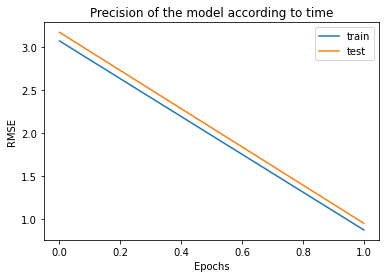

In [66]:
K= 3

U = np.random.random(size = (n, K))
M = np.random.random(size = (m, K))

class SVD_clusterize(Optimizer_clusterize):
    """Clusterize version of the SVD algorithm"""
    def __init__(self, latent_vector, mode, R=R_train, R_test=R_test, k_users=2, k_movies=10, lambda_reg=0.1, epochs=1):
        super().__init__(latent_vector, mode, R, R_test, k_users, k_movies, lambda_reg, epochs)

    def fit(self):
        t = time.time()
        self.run()
        self.score()
        self.test()
        self.update_time(t)
        if (self.mode == 'users'):
            for _ in range(self.epochs):
                for k in range(self.k_users):
                    R = self.submatrices_R[k]
                    R_test = self.submatrices_R_test[k]

                    svd = SVD(self.latent_vector, R=R, R_test=R_test, lambda_reg=self.lambda_reg, epochs=25)
                    self.submatrices_U[k], self.submatrices_M[k] = svd.fit()

                self.score()
                self.test()
                self.update_time(t)

        elif (self.mode == 'movies'):

            for _ in range(self.epochs):
                for k in range(self.k_movies):
                    R = self.submatrices_R[k]
                    R_test = self.submatrices_R_test[k]

                    svd = SVD(self.latent_vector, R=R, R_test=R_test, lambda_reg=self.lambda_reg, epochs=25)
                    self.submatrices_U[k], self.submatrices_M[k] = svd.fit()

                self.score()
                self.test()
                self.update_time(t)

        else:

            for _ in range(self.epochs):
                for k in range(self.k_users):
                    for k2 in range(self.k_movies):
                        R = self.submatrices_R[k][k2]
                        R_test = self.submatrices_R_test[k][k2]

                        svd = SVD(self.latent_vector, R=R, R_test=R_test, lambda_reg=self.lambda_reg, epochs=25)
                        self.submatrices_U[k][k2], self.submatrices_M[k][k2] = svd.fit()
                self.score()
                self.test()
                self.update_time(t)

        #self.plot_history()
        #print("time:", self.history["time"][-1])
        
svd_clusterize = SVD_clusterize(K, mode='users')
svd_clusterize.fit()
svd_clusterize.plot_history()

Verifying prediction of some ratings on the test set

In [162]:
col, row = np.where(R_test > 0)
S = list(zip(col, row))
U_alt, M_alt = U, M
#U_GD, M_GD = gradient_descent_nz(U, M, R, 0.00005, lambda_reg=0.002, mu_reg=0.002, epochs=200)
choices = np.random.choice(len(S), 10)
R_hat = np.round(U_svd @ M_svd.T, 1) 
#R_hat_clust = np.round(U_clust @ M_clust.T, 1) 
for choice in choices:
    i, j = S[choice]
    print("The real rate is : {}".format(R_test[i][j]))
    print("The estimate rate is : {}".format(R_hat[i][j]))
    #print("The clusterize estimate rate is {}".format(R_hat_clust[i][j]))
    print('')
    

The real rate is : 3.0
The estimate rate is : 3.4
The clusterize estimate rate is 3.4

The real rate is : 2.0
The estimate rate is : 2.8
The clusterize estimate rate is 2.8

The real rate is : 3.0
The estimate rate is : 2.9
The clusterize estimate rate is 2.9

The real rate is : 4.0
The estimate rate is : 4.0
The clusterize estimate rate is 4.0

The real rate is : 4.0
The estimate rate is : 3.7
The clusterize estimate rate is 3.7

The real rate is : 5.0
The estimate rate is : 3.5
The clusterize estimate rate is 3.5

The real rate is : 5.0
The estimate rate is : 4.2
The clusterize estimate rate is 4.2

The real rate is : 5.0
The estimate rate is : 3.2
The clusterize estimate rate is 3.2

The real rate is : 1.0
The estimate rate is : 2.4
The clusterize estimate rate is 2.4

The real rate is : 4.0
The estimate rate is : 3.6
The clusterize estimate rate is 3.6



# Gaussian Mixture

In [ ]:
class GaussianMixture(NamedTuple):
    """Tuple holding a gaussian mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds to a gaussian component mean
    var: np.ndarray  # (K, ) array - each row corresponds to the variance of a component
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component


def init(R: np.ndarray, K: int,
         seed: int = 0) -> Tuple[GaussianMixture, np.ndarray]:
    """Initializes the mixture model with random points as initial
    means and uniform assingments"""
    
    np.random.seed(seed)
    n, _ = R.shape
    p = np.ones(K) / K

    # select K random points as initial means
    mu = R[np.random.choice(n, K, replace=False)]
    var = np.zeros(K)
    # Compute variance
    for j in range(K):
        var[j] = ((R - mu[j])**2).mean()

    mixture = GaussianMixture(mu, var, p)
    post = np.ones((n, K)) / K

    return mixture, post


def rmse(X, Y):
    return np.sqrt(np.mean((X - Y)**2))

def bic(R: np.ndarray, mixture: GaussianMixture,
        log_likelihood: float) -> float:
    """Computes the Bayesian Information Criterion for a
    mixture of gaussians"""
    
    n, _ = R.shape
    mu = mixture.mu
    K, d = mu.shape
    p = K*(d+2) - 1
    return log_likelihood - 0.5*p*np.log(n)

def cluster_assignment(post: np.ndarray):
    """Compute the assignment for each cluster with the 
    probability of belonging to this cluster"""
    
    n, K = post.shape
    
    assignments = {j: [] for j in range(K)}
    
    for i in range(n):
        for j in assignments.keys():
            if post[i,j] != 0:
                assignments[j].append(i)
                
    return assignments

# EM Algorithm

In [ ]:
def log_gaussian(x: np.ndarray, mean: np.ndarray, var: float) -> float:
    """Computes the log probablity of vector x under a normal distribution"""
    
    d = len(x)
    log_prob = -d / 2.0 * np.log(2 * np.pi * var)
    log_prob -= 0.5 * ((x - mean)**2).sum() / var
    return log_prob

def estep(R: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component"""
    
    n, _ = R.shape
    mu, var, p = mixture
    K, _ = mu.shape
    post = np.zeros((n,K)) 
    ll = 0
    
    for i in range(n):
        mask = (R[i,:] != 0)
        
        for j in range(K):
            log_likelihood = log_gaussian(R[i,mask], mu[j, mask], var[j])
            post[i,j] = np.log(p[j] + 1e-16) + log_likelihood
        
        trick = logsumexp(post[i,:])
        post[i,:] = post[i,:] - trick
        ll += trick
        
    return np.exp(post), ll


def mstep(R: np.ndarray, post: np.ndarray, mixture: GaussianMixture,
          min_variance: float = .25) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset"""
    
    n, d = R.shape
    mu = mixture.mu.copy()
    K, _ = mu.shape
    var = np.zeros(K)
    
    n_hat = post.sum(axis=0)
    p = n_hat/n
    
    for j in range(K):
        sse = 0
        weight = 0
        for l in range(d):
            mask = (R[:,l] != 0)
            n_sum = post[mask,j].sum()
            if n_sum > 0:
                #update mean
                mu[j,l] = (R[mask,l] @ post[mask,j])/n_sum
                
            #compute variance

            sse += ((mu[j,l] - R[mask,l])**2) @ post[mask, j]
            weight += n_sum
            #print(weight)
        
        var[j] = sse/weight
        if var[j] < min_variance:
            var[j] = min_variance
        
    return GaussianMixture(mu, var, p)


def run(R: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model"""
    
    old_ll = None
    new_ll = None
    
    while(old_ll is None or (new_ll - old_ll) > 1e-6*abs(new_ll)):
        
        old_ll = new_ll
        post, new_ll = estep(R, mixture)
        mixture = mstep(R, post, mixture)
        
    return mixture, post, new_ll


def fill_matrix(R: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """Fills an incomplete matrix according to a mixture model"""
    
    n, d = R.shape
    R_hat = R.copy()
    K, _ = mixture.mu.shape

    for i in range(n):
        mask = (R[i, :] != 0)
        mask0 = (R[i, :] == 0)
        post = np.zeros(K)
        for j in range(K):
            log_likelihood = log_gaussian(R[i, mask], mixture.mu[j, mask],
                                          mixture.var[j])
            post[j] = np.log(mixture.p[j]) + log_likelihood
        post = np.exp(post - logsumexp(post))
        R_hat[i, mask0] = post @ mixture.mu[:, mask0]
    
    return R_hat